<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

In [ ]:
# install dependencies:
!pip install pyyaml==5.1
!pip install Pillow==5.3.0
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
!gcc --version

In [ ]:
import torch, torchvision
import torch
assert torch.__version__.startswith("1.7")
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random, glob
from google.colab.patches import cv2_imshow
from os import listdir
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Cannot detect lamp objects

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

model_final_f10217.pkl: 178MB [00:01, 94.4MB/s]                           


/usr/local/lib/python3.6/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:124: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


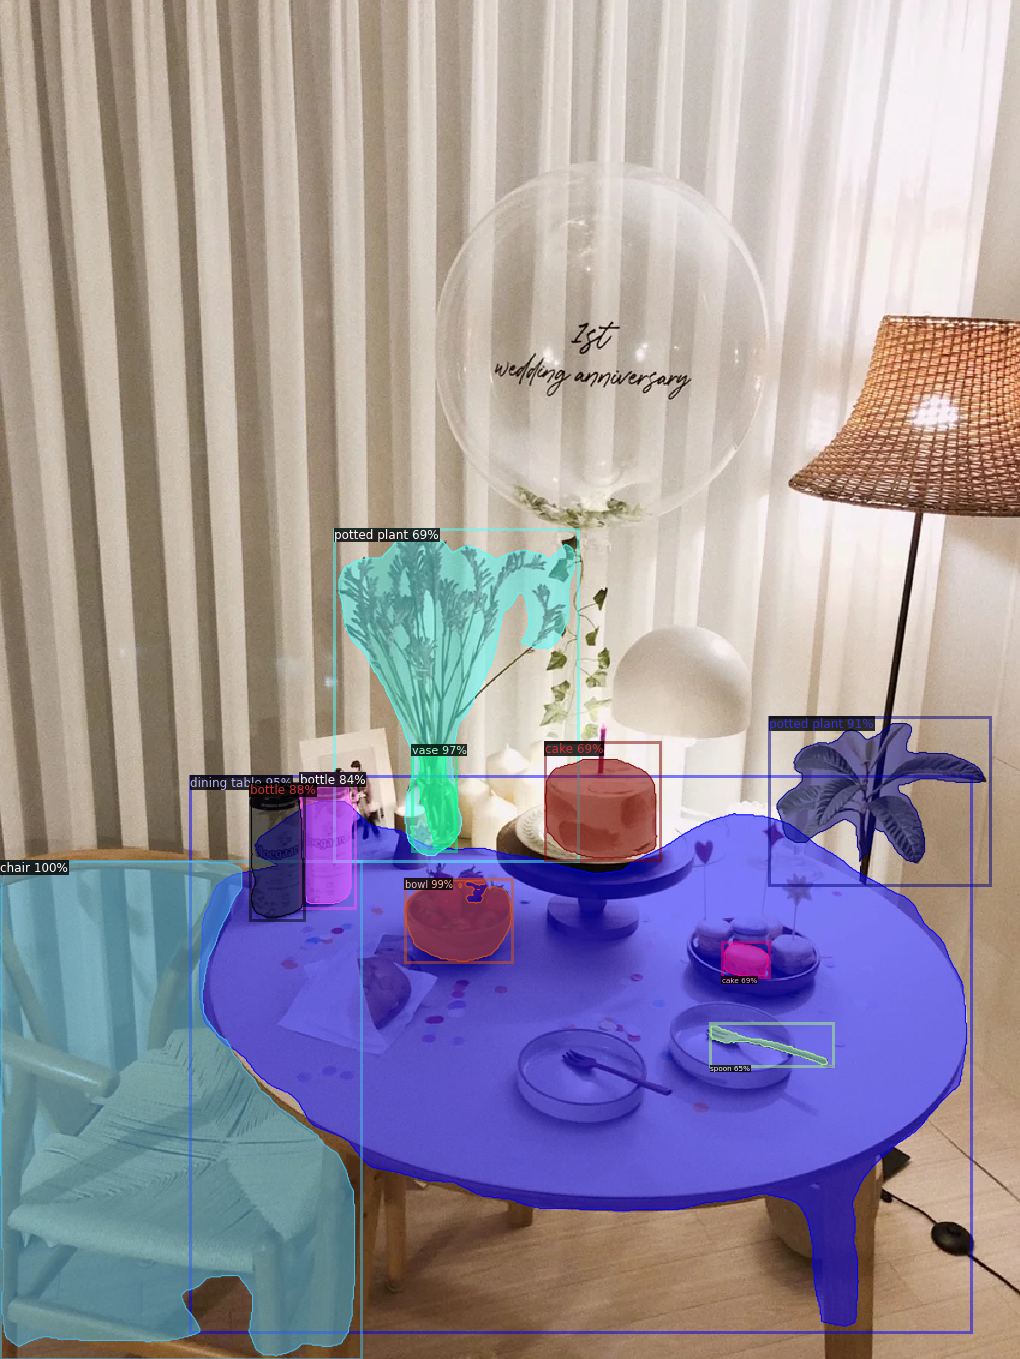

In [ ]:
im2 = cv2.imread("/content/drive/MyDrive/Colab Notebooks/dl_project/test_img.jpg")

outputs2 = predictor(im2)
v2 = Visualizer(im2[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out2 = v2.draw_instance_predictions(outputs2["instances"].to("cpu"))
cv2_imshow(out2.get_image()[:, :, ::-1])

# Fine Tuning
 - Labelling more than 1k Lamp images in Roboflow.com

In [ ]:
!curl -L "https://app.roboflow.com/ds/GzlANAXgjt?key=I8YM2dQw9C" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

## Register dataset

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/train/_annotations.coco.json", "/content/train")
register_coco_instances("my_dataset_val", {}, "/content/valid/_annotations.coco.json", "/content/valid")
register_coco_instances("my_dataset_test", {}, "/content/test/_annotations.coco.json", "/content/test")

## Visualize training data

WARNING [02/12 14:58:46 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[02/12 14:58:46 d2.data.datasets.coco]: Loaded 1610 images in COCO format from /content/train/_annotations.coco.json


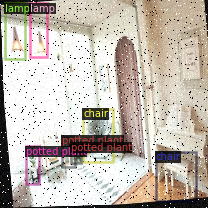

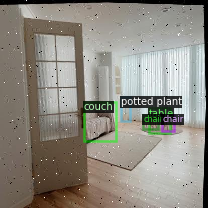

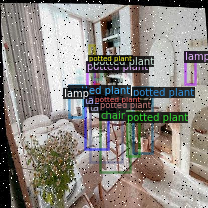

In [ ]:
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

## Train and evaluate our model

In [ ]:
#We are importing our own Trainer Module here to use the COCO validation evaluation during training. Otherwise no validation eval occurs.

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [ ]:
#from .detectron2.tools.train_net import Trainer
#from detectron2.engine import DefaultTrainer
# select from modelzoo here: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-object-detection-baselines

from detectron2.config import get_cfg
#from detectron2.evaluation.coco_evaluation import COCOEvaluator
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001

cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 2000 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 175 #your number of classes + 1

cfg.TEST.EVAL_PERIOD = 500

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[02/12 15:00:12 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_68b088.pkl: 421MB [00:05, 78.1MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (176, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (176,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (700, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (700,) in the model! You might want to double check if this is expected.


[02/12 15:00:18 d2.engine.train_loop]: Starting training from iteration 0
[02/12 15:00:56 d2.utils.events]:  eta: 1:04:37  iter: 19  total_loss: 6.439  loss_cls: 5.204  loss_box_reg: 0.919  loss_rpn_cls: 0.3193  loss_rpn_loc: 0.04101  time: 1.9193  data_time: 0.0288  lr: 1.9981e-05  max_mem: 9775M
[02/12 15:01:38 d2.utils.events]:  eta: 1:06:42  iter: 39  total_loss: 5.776  loss_cls: 4.712  loss_box_reg: 0.9086  loss_rpn_cls: 0.1197  loss_rpn_loc: 0.03139  time: 2.0226  data_time: 0.0154  lr: 3.9961e-05  max_mem: 9775M
[02/12 15:02:19 d2.utils.events]:  eta: 1:06:02  iter: 59  total_loss: 4.346  loss_cls: 3.341  loss_box_reg: 0.9287  loss_rpn_cls: 0.1982  loss_rpn_loc: 0.03931  time: 2.0220  data_time: 0.0164  lr: 5.9941e-05  max_mem: 9775M
[02/12 15:02:59 d2.utils.events]:  eta: 1:05:16  iter: 79  total_loss: 2.797  loss_cls: 1.719  loss_box_reg: 0.9225  loss_rpn_cls: 0.07179  loss_rpn_loc: 0.03735  time: 2.0211  data_time: 0.0149  lr: 7.9921e-05  max_mem: 9775M
[02/12 15:03:40 d2.uti

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [ ]:
#test evaluation
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [02/12 16:12:13 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass tasks in directly
WARNING [02/12 16:12:13 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[02/12 16:12:13 d2.data.datasets.coco]: Loaded 115 images in COCO format from /content/test/_annotations.coco.json
[02/12 16:12:13 d2.data.build]: Distribution of instances among all 7 categories:
|  category  | #instances   |  category  | #instances   |   category   | #instances   |
|:----------:|:-------------|:----------:|:-------------|:------------:|:-------------|
| floorstand | 0            |   chair    | 127          |    clock     | 17           |
|   couch    | 57           |    lamp    | 117          | potted plant | 129          |
|   table    | 74           |            |              |              |              |
|   total    | 521          |            |              |           

OrderedDict([('bbox',
              {'AP': 45.10550621247315,
               'AP-chair': 51.78367170625935,
               'AP-clock': 29.64156854765309,
               'AP-couch': 62.46126820071888,
               'AP-floorstand': nan,
               'AP-lamp': 38.38159965868774,
               'AP-potted plant': 40.64673164076323,
               'AP-table': 47.718197520756576,
               'AP50': 74.76369711252481,
               'AP75': 48.08632772972013,
               'APl': 53.97379982795124,
               'APm': 44.488671342917414,
               'APs': 17.498737664516117})])

In [ ]:
%ls ./output/

coco_instances_results.json                        last_checkpoint
events.out.tfevents.1613141985.5e18a46446f7.138.0  metrics.json
events.out.tfevents.1613142012.5e18a46446f7.138.1  model_final.pth
instances_predictions.pth


In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("my_dataset_test", )   
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_dataset_test")

In [ ]:
from detectron2.utils.visualizer import ColorMode
import glob

for imageName in glob.glob('/content/test/*jpg'):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata, 
                scale=0.8
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])


# Sample
 - Detect 2 table lamps but one of those is a balloon :(
 - Miss 1 stand lamp
 - Need more work

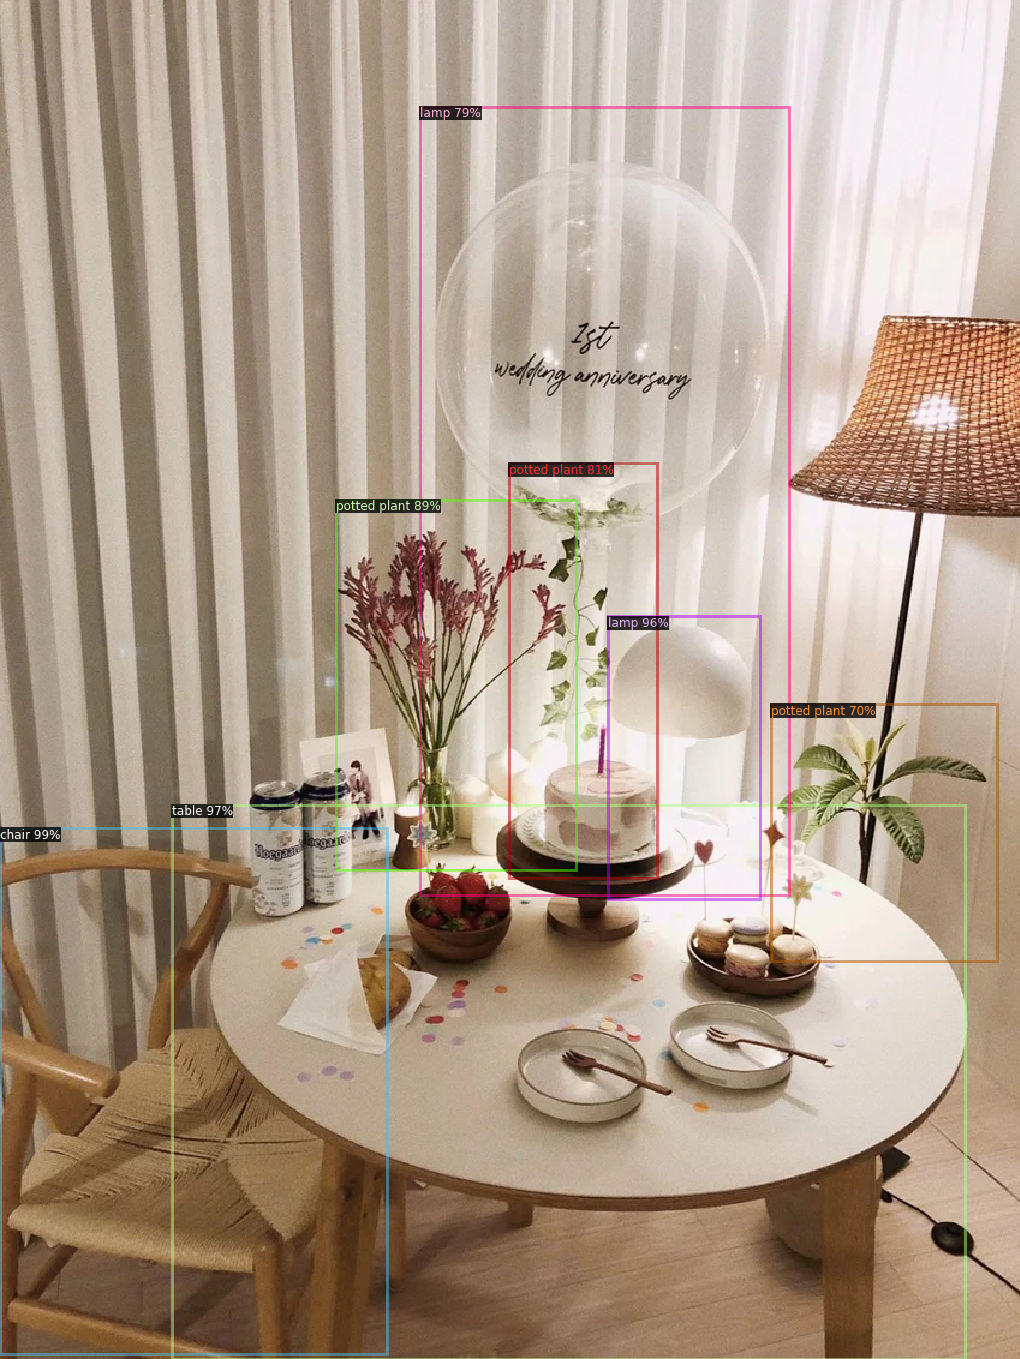

In [ ]:
im = cv2.imread("/content/drive/MyDrive/Colab Notebooks/dl_project/test_img.jpg")
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])